# Variational Bayesian Inference

In this notebook, we will review the variational Bayes process, beginning with a technical introduction to the formalism and derivation, followed by a python implementation. 
The material covered here references Blei et al., 2018, Varitional Inference: A Review for Statisticians and Chappel et al., 2016. The FMRIB Variational Bayes Tutorial. 


## Technical Overview

### Problem Statement 

Similarly to problems addressed by sampling methods, the goal of variational inference (VI) is to approximate parameter distributions from data, specifically in cases where an analytical treatment is intractable. 

Consider the following example (from Blei et al., 2018): 

For latent variabels $\mathbf{z} = z_{1:m}$ and observations $\mathbf{x} = x_{1:n}$, the posterior conditional density is given by : 

$$ p(\mathbf{z} \mid \mathbf{x}) = \frac{p(\mathbf{x} \mid \mathbf{z}) * p(\mathbf{z})}{p(\mathbf{x})} $$

The denominator, ${p(\mathbf{x})}$, whose value is needed to compute the posterior, is calculated by: 

$$ {p(\mathbf{x})} = \int p(\mathbf{z} , \mathbf{x}) dz $$


This integral is often intractable or too computationally expensive to be feasible. For similar reasons (notably the number of latent variables)sampling methods are slow to converge.

VI aims to circumvent the large time complexity by approaching the problem through optimisation. 

The process begins by positing a contrived _approximate_ density, $\mathfrak{D}$ of latent variables $\mathbf{z}$. Then, using this density can find a set of valuers for $q(\mathbf{z}) \in \mathfrak{D}$ whose values maximise the Kullback-Liebler divergence between the approximate density and the true posterior. 

$$ q^{*}(\mathbf{z}) = \underset{q(\mathbf{z}) \in \mathfrak{D}}{argmin} \mathrm{KL}(q(\mathbf{z}) \mid \mid p(\mathbf{z} \mid \mathbf{x})) $$


### VI Computation 

To compute the optimsation problem stated above requires we do manipulation of the terms. This is because the problem is still dependent on the _evidence_ term ($p(\mathbf{x})$; recall, the intragral of this is often difficult/intractable). To see this clearly, we can rewrite out expression using Bayes rule: 

$$ q^{*}(\mathbf{z}) = \underset{q(\mathbf{z}) \in \mathfrak{D}}{argmin} \mathrm{KL}\bigg(q(\mathbf{z}) \mid \mid \frac{p(\mathbf{z}, \mathbf{x})}{p(\mathbf{x})}\bigg) $$

We can avoid evidence term using the following manipulations. First, let's break down the KL divergence, recalling that the KL divergence can otherwise be expressed as the expectated value of the first argument minus the expected value of the second argument: 

$$ KL(q(\mathbf{z}) \mid \mid p(\mathbf{z} \mid \mathbf{x})) = \mathbb{E}[\log q(\mathbf{z})] - \mathbb{E}[\log p(\mathbf{z} , \mathbf{x})] + \log p(\mathbf{x}) $$

We formulate the Evidence Lower Bound (ELBO) by multiplying both sides by -1: 


\begin{align}
 ELBO(q) &= - KL(q(\mathbf{z}) \mid \mid p(\mathbf{z} \mid \mathbf{x})) + \log p(\mathbf{x}) \\
 
         &= \mathbb{E}[\log p(\mathbf{z}, \mathbf{x})] - \mathbb{E}[\log q(\mathbf{z})]
\end{align}

Note that, maximsing the ELBO is the same as minimising the KL divergence, since the evidence is constant and additive. 

By exanding the joint probaibility, we can rewrite the ELBO in terms of the log likelihood and KL divergence between our prior $p(\mathbf{z})$ and our variational density $q(\mathbf{z})$: 

\begin{align}
ELBO(q) &= \mathbb{E}[\log p(\mathbf{x} \mid \mathbf{z})] + \mathbb{E}[\log p(\mathbf{z})] - \mathbb{E}[\log q(\mathbf{z})] \\

&= \mathbb{E}[\log p(\mathbf{x} \mid \mathbf{z})] - KL(q(\mathbf{z}) \mid \mid p(\mathbf{z}))
\end{align}

By maximising the ELBO or minimising the KL divergence, we can solve the optimisation problem. Now, we need a method to do this.

### Optimisation 

There are many method available for solving the optimsation problem. Here we appeal to variational calculus (hence, variational inference). 

Full derivation to follow... 

Optimisation equates to updating parameters w.r.t the expectation of all other parameters given the current posterior:

$$ \log q(z_i) \approx \int q(z_{-i}) \log p(x \mid z) p(w) dw_{-i}$$ 


## Example 

We will work with an exponential decay model to explore the variational Bayes framework and derive further equations needed. 

### Model Definition 

$$ y = ae^{-\lambda t} + \epsilon $$
$$ \epsilon = \mathcal{N}(0,\phi^{1}) $$

We can define this using a simple lambda function and some parameter values. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt 

In [3]:
def f(theta, t): 
    """ Sipmle exponential decay model

    args: 
    theta : array, float
            parameters for function
        t : array, float 
            timesteps to evaluate at
    """
    a, l = theta
    f1 = a * np.exp(-l * t)

    return f1

In [4]:
a = 42
l = 1.5
theta = [a, l]
t = np.linspace(0,20,100)

phi = 100 

In [5]:
model = f(theta, t)
data = f(theta, t) + np.random.normal(0, np.sqrt(1/10), t.shape[0])

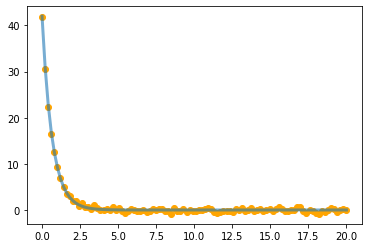

In [34]:
plt.plot(t, model, linewidth = 3, alpha = 0.6)
plt.scatter(t, data, c = 'orange')
plt.show()

#### Forward Model Specification

We can set up a forard model in the following way:

$$ \mathbf{y} = \mathbf{g} + \epsilon $$ 

$$ \mathbf{g} = \{g(\theta_{1}), . . ., g(\theta_{k})\} $$

$$ \epsilon \approx \mathcal{N}(0, \Phi^{-1}) $$ 

$$ \Phi = \{\phi_1, . . ., \phi_n\} $$

Where $\mathbf{y}$ is a vector of N observation assumed to be generated by a nonlinear forward function $g(\theta) + \epsilon $ with $k$ parameters, \theta, and $k$ precision parameters, $\phi$. 



#### Inference Specification

Using this forward model, we can parameterise the log-likelihood as multivariate normal distribution, with the data conditioned on parameters:

$$ p(\mathbf{y} \mid \mathbf{\Theta}) = \frac{N}{2} \log(\Phi) - \frac{1}{2}(\mathbf{y} - \mathbf{g})^{T} \Phi (\mathbf{y} - \mathbf{g}) $$

Where $\Theta$ is the set of independent parameters. We factorise the approximate posterior accordingly: 

$$ q(\Theta \mid \mathbf{y}) = q(\theta_n)q(\phi_n) $$ 

and choose conjucate distributions for their form: 

$$ q(\theta \mid \mathbf{y}) \approx MVN(\theta; \mathbf{m}, \Lambda^{-1}) $$ 

$$ q(\phi \mid \mathbf{y}) \approx Ga(\phi; s, c) $$ 

Using these, we can construct the log posterior and thus update equations. 

\begin{align}
L &= \log p(\mathbf{y} \mid \mathbf{\Theta}) + \log p(\theta) + \log p(\phi) \\
&= \underbrace{\frac{N}{2} \log(\Phi) - \frac{1}{2}(\mathbf{y} - \mathbf{g})^{T} \Phi (\mathbf{y} - \mathbf{g})}_{\log p(\mathbf{y} \mid \mathbf{\Theta})} 
- \underbrace{\frac{1}{2}(\theta - \mathbf{m_0})^{T} \Lambda_0 (\theta - \mathbf{m_0})}_{\log p(\theta)}
+ \underbrace{(c_0 - 1)\log\phi - \frac{1}{s_0} \phi}_{\log p(\phi)}
+ \underbrace{const\{\theta, \phi\}}_{\text{constant terms}}
\end{align}


##### Compuational side note: 

We will need to make an approximation to the function $g(\theta)$ for mathematical and computational convenience. Simply, we will take a first order Taylor expansion around the mean of the posterior distribution. 

$$ g(\theta) \approx g(\mathbf{m}) + \mathbf{J}(\theta - \mathbf{m}) $$ 

Where $\mathbf{m}$ is the mean value and $\mathbf{J}$ is the Jacobian matrix. 

In practice, we will compute this approximation using a simply central difference scheme. Let's define some functions to do this for us. 

In [6]:
def time_step(theta): 
    """Control time stepping interval proportional to the parameter magnitiude. 

    args: 
    theta:: float 
    """

    delta = theta * 1e-5

    if delta < 0:
            delta = -delta
    if delta < 1e-10:
            delta = 1e-10
    
    return delta

def central_difference(i, theta, delta, t):
    """ Calculate the derivate using a first order central difference approximation

    args: 
        i : int 
            parameter index
    theta : np.array float 
            array of paramters for function, f
    delta : float 
            time-step for central difference
        t : np.array float
            time steps to evaluate at
    returns: 
        df : np.array, float 
             first order approximation, df, for time steps, t
    """
    dtheta = np.array(theta), np.array(theta)

    dtheta[0][i] += delta
    dtheta[1][i] -= delta
    df = (f(dtheta[0], t) - f(dtheta[1], t)) / (2 * delta)
    return df

def Jacobian(theta, t):
    """Compute the Jacobian for globally defined function, f, with parameter set Theta 

    args:
    theta : np.array, float
            parameters of global function, f
        t : np.array, float 
            time steps to evaluate at

    returns: 
        J : np.array, float
            Jacobian vector/matrix evaluated at theta, t. 
    """
    J = None
    #f_n = len(f)
    p_n = len(theta)

    for i in range(p_n):
        delta = time_step(theta[i])
        if J is None:
                J = np.zeros([len(t), len(theta)], dtype=np.float32)
        J[:,i] = central_difference(i, theta, delta, t)
    
    return J

### Deriving updates

For our model, we will need to derive updates on our model parameters $\theta$ and noise parameters $phi$. 

Recall the the derivation for our updates w.r.t. the free energy functional: 

$$ p(\theta_{i}) = \int p(\Theta \mid y) p(\theta_{-i}) d\theta_{-i} $$ 

Where $\theta_{-i}$ are all parameters that are not $\theta$. In our case, we have two parameters $\theta$ and $\phi$. Which will be given by: 

$$ p(\theta) = \int p(\Theta \mid y) p(\phi) d\phi $$ 

and 

$$ p(\phi) = \int p(\Theta \mid y) p(\theta) d\theta $$

#### Update on theta 

We will first derive our update on model parameters $\theta$.

Recall the forms of the log posterior and parameters. With these, we can write down the full form of the update equation: 

$$
q(\theta) =  
\int 
\bigg( \frac{N}{2} \log(\phi) - \frac{1}{2}(\mathbf{y} - \mathbf{g})^{T} \Phi (\mathbf{y} - \mathbf{g})
- \frac{1}{2}(\theta - \mathbf{m_0})^{T} \Lambda_0 (\theta - \mathbf{m_0})
+ (c_0 - 1)\log\phi - \frac{1}{s_0} \phi
+ const\{\theta, \phi\} \bigg) Ga(\phi; s, c) d\phi
$$

Where $\mathbf{g}$ is an abbreviation for the function $g(\theta)$. We can start simplifying this by first removing terms from that are constant w.r.t. $\theta$ (remember, we are trying to optimise $\theta$) and factoring out terms in the intregral constant w.r.t. $\phi$. 

In so doing, we arrive at the following: 
$$ 
q(\theta) =  

- \frac{1}{2}(\theta - \mathbf{m_0})^{T} \Lambda_0 (\theta - \mathbf{m_0})
- \frac{1}{2}(\mathbf{y} - \mathbf{g})^{T}(\mathbf{y} - \mathbf{g})
\int \phi Ga(\phi; s, c) d\phi
+ const{\theta}
$$ 

The integral term corresponds to the mode of the Gamme distribution, which, since we are using precision (the inverse of variance), is equal to $sc$. Thus, we have: 

$$
q(\theta) =  
- \frac{1}{2}(\theta - \mathbf{m_0})^{T} \Lambda_0 (\theta - \mathbf{m_0})
- \frac{1}{2}sc(\mathbf{y} - \mathbf{g})^{T}(\mathbf{y} - \mathbf{g})
+ const{\theta}
$$

To complete the derivation, we substitute the function $\mathbf{g}$ for it's Taylor approximation, given above and restated here. 

$$ g(\theta) \approx g(\mathbf{m}) + \mathbf{J}(\theta - \mathbf{m}) $$ 
$$ \mathbf{y} - \mathbf{g} = \mathbf{k} + \mathbf{J}(\theta - \mathbf{m})$$ 

Substituting this in and droppping the constant term, we obtain: 
$$
q(\theta) =  
- \frac{1}{2}(\theta - \mathbf{m_0})^{T} \Lambda_0 (\theta - \mathbf{m_0})
- \frac{1}{2}sc(\mathbf{k} + \mathbf{J}(\theta - \mathbf{m}))^{T}(\mathbf{k} + \mathbf{J}(\theta - \mathbf{m}))
$$

Expanding this out: 
$$
q(\theta)  =
-\frac{1}{2} \bigg(
\theta^{T}\Lambda_0\theta + \theta^{T}\Lambda_0 \mathbf{m_0} + m_0^{T}\Lambda_0\theta + \mathbf{m_0}\Lambda_0 \mathbf{m_0}
+ sc (\theta^{T}\mathbf{J}^{T}\mathbf{J}\theta + \theta^{T}\mathbf{J}^{T}\mathbf{k} - \theta^{T}\mathbf{J}^{T}\mathbf{Jm} + \mathbf{kJ}\theta + \mathbf{m}^{T}\mathbf{J}^{T}\mathbf{J}\theta) \bigg)
$$
We can then exlude terms that do not depend on $\theta$ and group like terms together
$$
= -\frac{1}{2} \bigg(
\theta^{T}\Lambda_0\theta + sc \theta^{T}\mathbf{J}^{T}\mathbf{J}\theta 
+ \theta^{T}\Lambda_0 \mathbf{m_0} + \theta^{T}\mathbf{J}^{T}k - \theta^{T}\mathbf{J}^{T}\mathbf{Jm}
+ \mathbf{m_0}^{T}\Lambda_0\theta + \mathbf{kJ}\theta + \mathbf{m}^{T}\mathbf{J}^{T}\mathbf{J}\theta \bigg)
$$
Which can be factorised as: 
$$
= -\frac{1}{2} \bigg(
\theta^T(\Lambda_0 + dc \mathbf{J}^T \mathbf{J})\theta - \theta^T(\Lambda_0 \mathbf{m_0} + sc\mathbf{J}(\mathbf{k + Jm})) - (\Lambda_0 \mathbf{m_0} + sc\mathbf{J}(\mathbf{k + Jm})^T \theta \bigg)
$$

Remember we specify the log posterior as a multivariate normal distribution. Thus, analysing the corresponding coefficients given by the multivariate normal form, we arrive at the update equations: 

$$ 
\Lambda = sc \mathbf{J}^T \mathbf{J} + \Lambda_0
\\ 
\text{and}
\\ 
\mathbf{m} = \Lambda^{-1} ( sc \mathbf{J}^T (\mathbf{k + Jm}) + \Lambda_0 \mathbf{m_0}) 
$$

We can write a simple function to compute this update:

In [3]:
def parameter_update(error, params, priors, J):
    """ Update forward model function parameters theta in accordance with the update equations above
    
    args: 
        error : array, float
                vector of the difference between observations and model prediction 
       params : tuple
                parameters values
       priors : tuple 
                priors values
            J : array, float 
                array of Jacbian values from the model given parameter updates (calculated above)
    """
    m, p, s, c = params
    m0, p0, _, _ = priors

    p_new = s*c*np.dot(J.transpose(), J) + p0
    c_new = np.linalg.inv(p_new)
    m_new = np.dot(c_new, (s * c * np.dot(J.transpose(), (error +    np.dot(J, m))) + np.dot(p0, m0)))
    
    params[0][:], params[1][:] = m_new, p_new

    return params

#### Update on noise

In [9]:
def noise_update(error, params, priors, J):
    _, p, _, _ = params 
    _, _, s0, c0 = priors

    N = len(data)

    c = np.linalg.inv(p)
    c_new = N/2 + c0
    s_new = 1/(1/s0 + 1/2 * np.dot(error.transpose(), error) + 1/2 * np.trace(np.dot(c, np.dot(J.transpose(), J))))
    
    params[2][:], params[3][:] = c_new, s_new

    return params

In [7]:
def error_update(y, theta, t):
    """Calculate difference between data and model with updated parameters

    args:
        y : array, float 
            vector of noisy data (observations)
    theta : array, float
            vector of parameter values for model, f
        t : array, float 
            vector of time steps at which to evaluate model 
    
    returns:
    error : array, float 
            vector of difference between noisy data and updated model
    """


    error = y - f(theta[:2], t)
    
    return error

In [15]:
def fit(data, params, priors, t, n): 
    

    for i in range(20):
        theta = params[0]
        error = error_update(data, theta, t)
        
        J = Jacobian(theta, t)
        params = parameter_update(error, params, priors, J)
        params = noise_update(error, params, priors, J)

    print(results)
    return params


In [11]:
m = np.array([1.0, 1.0])
C = np.array([[1.0, 0], [0.0, 1.0]])
p = np.linalg.inv(C)
c = np.array([1e-8])
s = np.array([50.0])

params = m, p, c, s

In [12]:
m0 = np.array([1.0, 1.0])
a_var0, lam_var0 = np.array([1000, 1.0])
C0 = np.array([[a_var0, 0], [0, lam_var0]])
p0 = np.linalg.inv(C0)
 

beta_mean0 = 1
beta_var0 = 1000
# c=scale, s=shape parameters for Gamma distribution
c0 = beta_var0 / beta_mean0
s0 = beta_mean0**2 / beta_var0

priors = m0, p0, c0, s0 

In [16]:
results = fit(data, params, priors, t, n=100)

(array([41.7178877,  1.4921204]), array([[  29.49746775, -300.46124063],
       [-300.46124063, 8654.44398325]]), array([50.001]), array([0.26709405]))
